Drive: https://drive.google.com/drive/folders/1nqlc7Zz92M5mj2NKjwUTwC8hOt9GLlIn?usp=sharing

In [1]:
import pandas as pd

def clean_repo(df, repo_id, new_id, cutoff=4000):
    """
    Filters one repository, keeps rows only until first occurrence 
    of stars >= cutoff, renames repo ID.
    """
    repo_df = df[df["repository_id"] == repo_id].copy()

    # Cleaning
    repo_df["timestamp"] = pd.to_datetime(repo_df["timestamp"])
    repo_df = repo_df.sort_values("timestamp")
    repo_df = repo_df.drop_duplicates()

    # Keep only until cumulative stars reaches cutoff
    cutoff_index = repo_df[repo_df["stars"] >= cutoff].index
    if len(cutoff_index) > 0:
        last_index = cutoff_index[0]
        repo_df = repo_df.loc[:last_index]

    repo_df["repository_id"] = new_id

    # Save cleaned CSV
    filename = f"{new_id}_cleaned.csv"
    repo_df.to_csv(filename, index=False)
    print(f"Saved: {filename} with {len(repo_df)} rows")

    return repo_df

df = pd.read_csv("Dataset/Q3/stars_data.csv")

# Clean both repositories
clean_repo(df, "facebook/react", "facebook-react")
clean_repo(df, "pallets/flask", "pallets-flask")

Saved: facebook-react_cleaned.csv with 260 rows
Saved: pallets-flask_cleaned.csv with 985 rows


,timestamp,stars,repository_id
8190,2010-04-06,1541,pallets-flask
8191,2010-04-07,1545,pallets-flask
8192,2010-04-08,1549,pallets-flask
8193,2010-04-09,1552,pallets-flask
8194,2010-04-10,1556,pallets-flask
...,...,...,...
9170,2012-12-11,3997,pallets-flask
9171,2012-12-12,3998,pallets-flask
9172,2012-12-13,3999,pallets-flask
9173,2012-12-14,3999,pallets-flask



Processing: facebook-react

Exploring data...


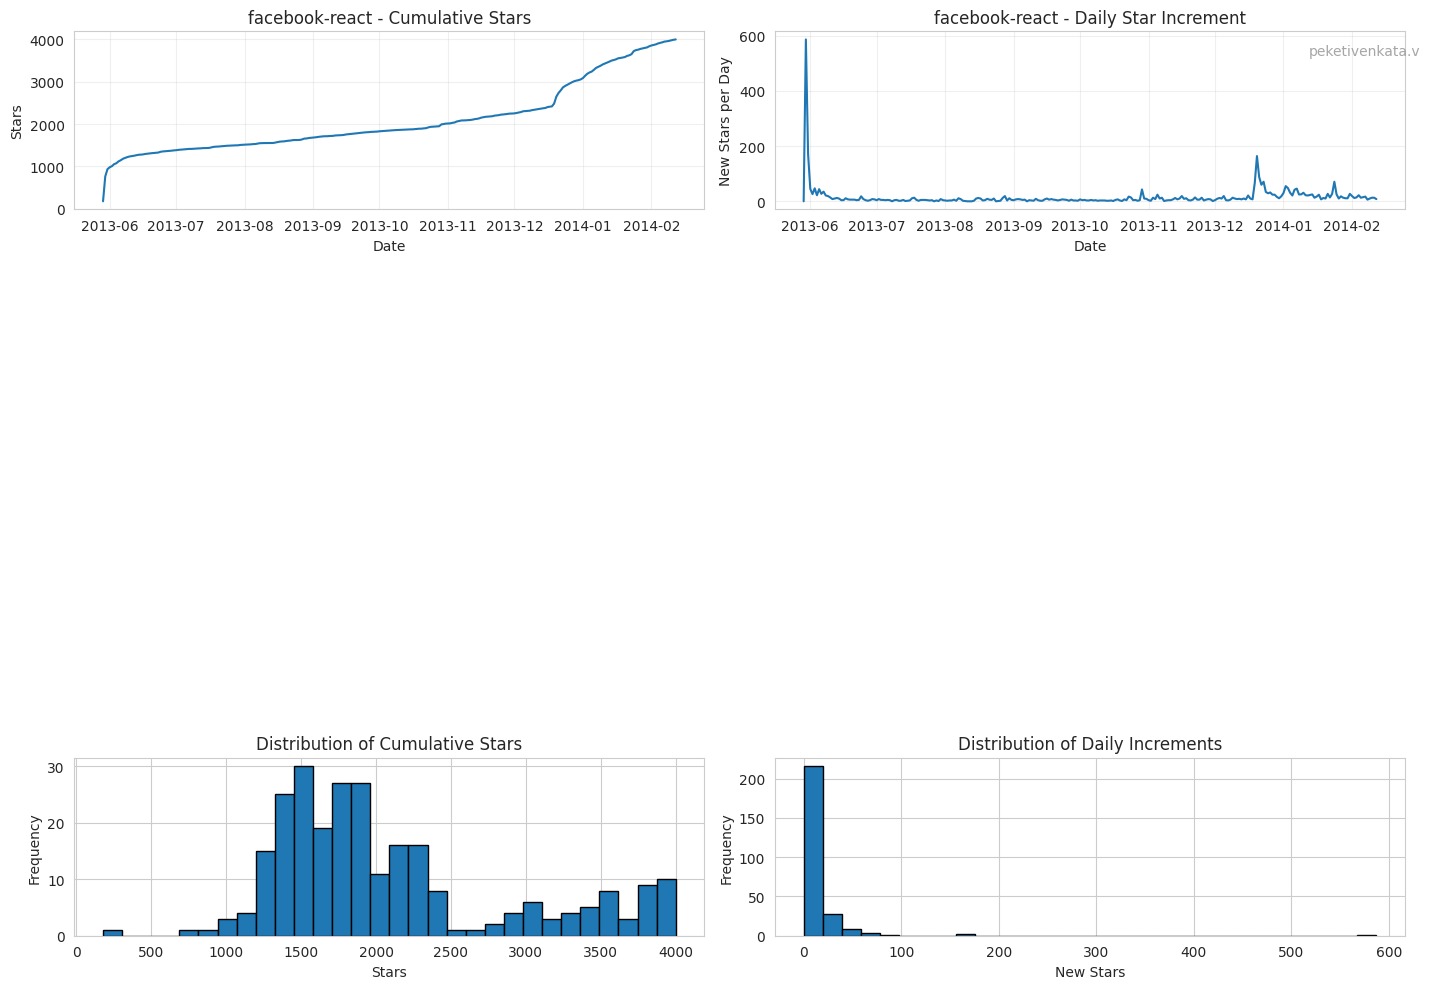


--- Processing cumulative data ---
Training and evaluating models...


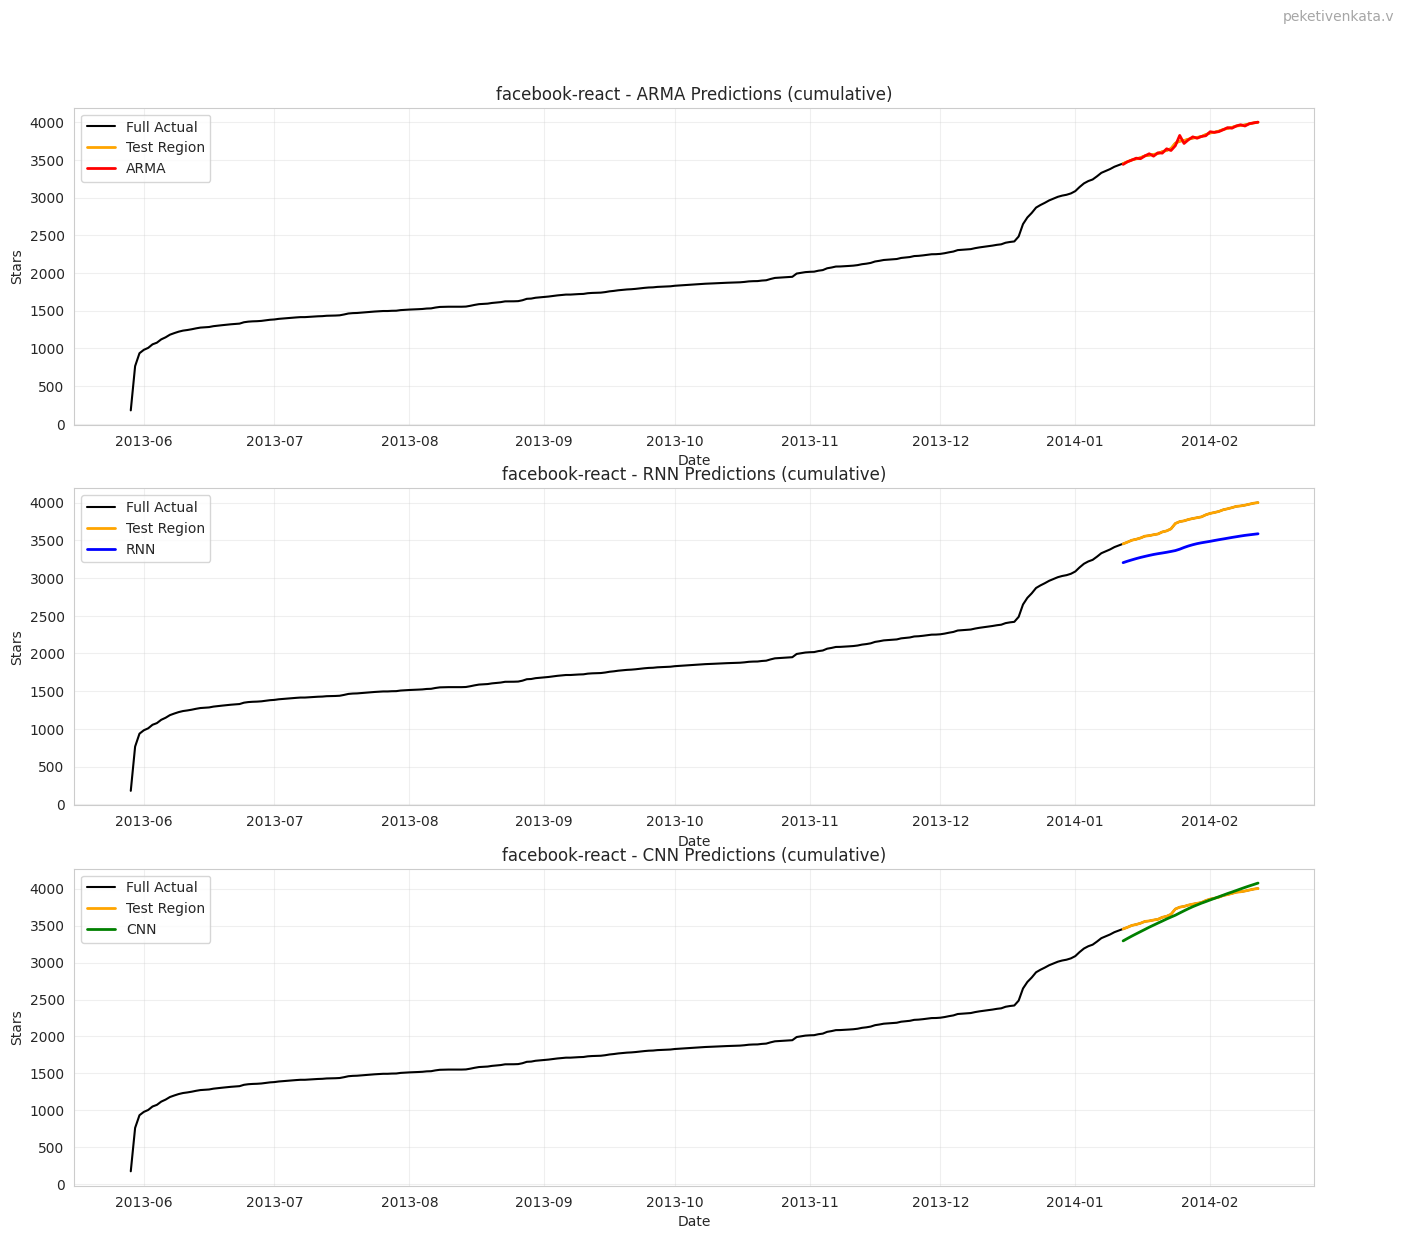

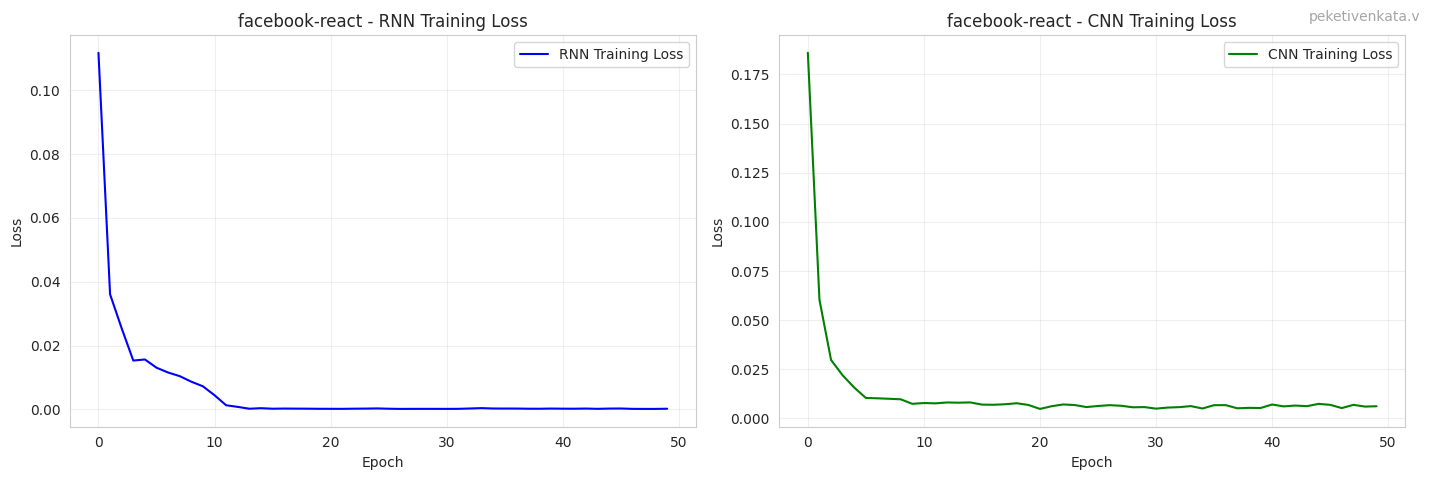

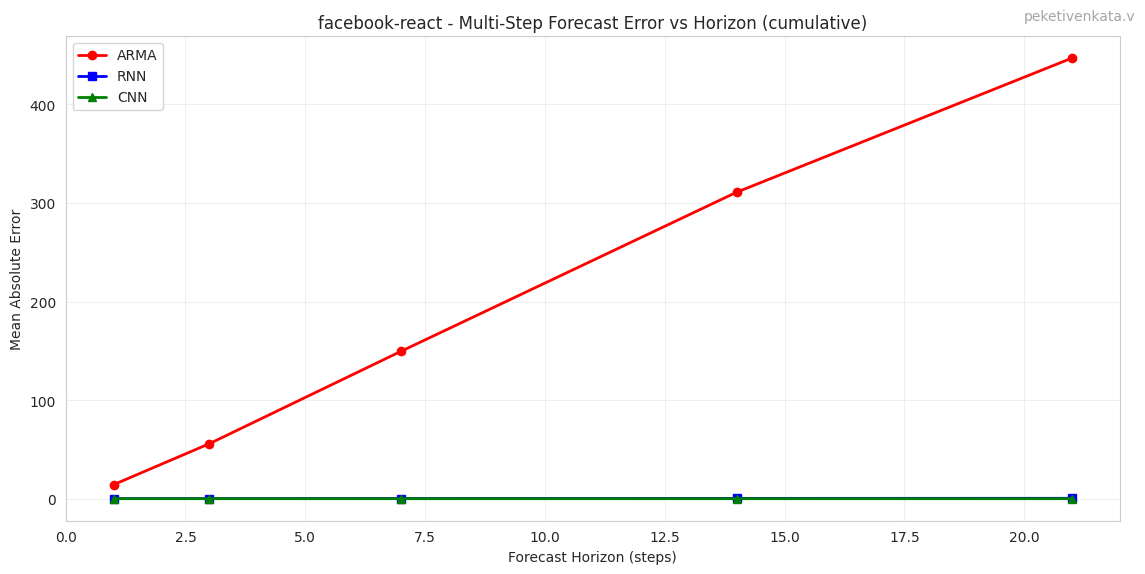


Results for facebook-react (cumulative):
Model      MAE             RMSE           
----------------------------------------
ARMA       14.3824         20.7294        
RNN        335.7124        340.6105       
CNN        57.6467         72.5799        

--- Processing incremental data ---
Training and evaluating models...


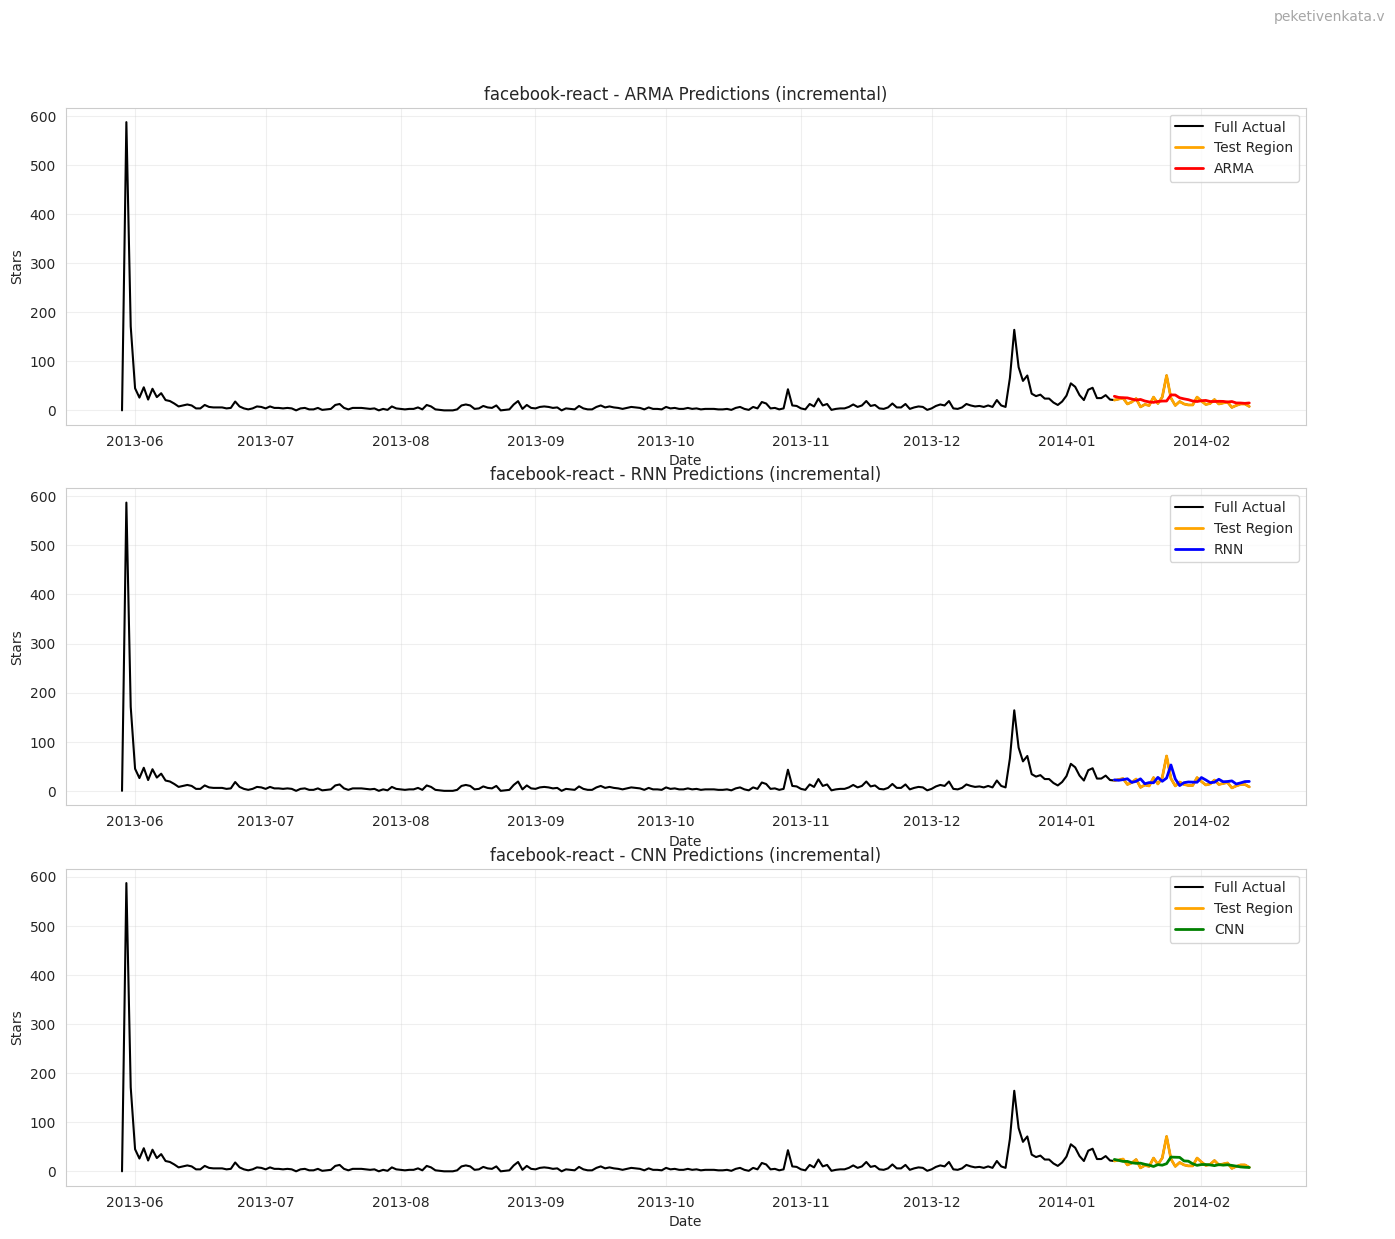

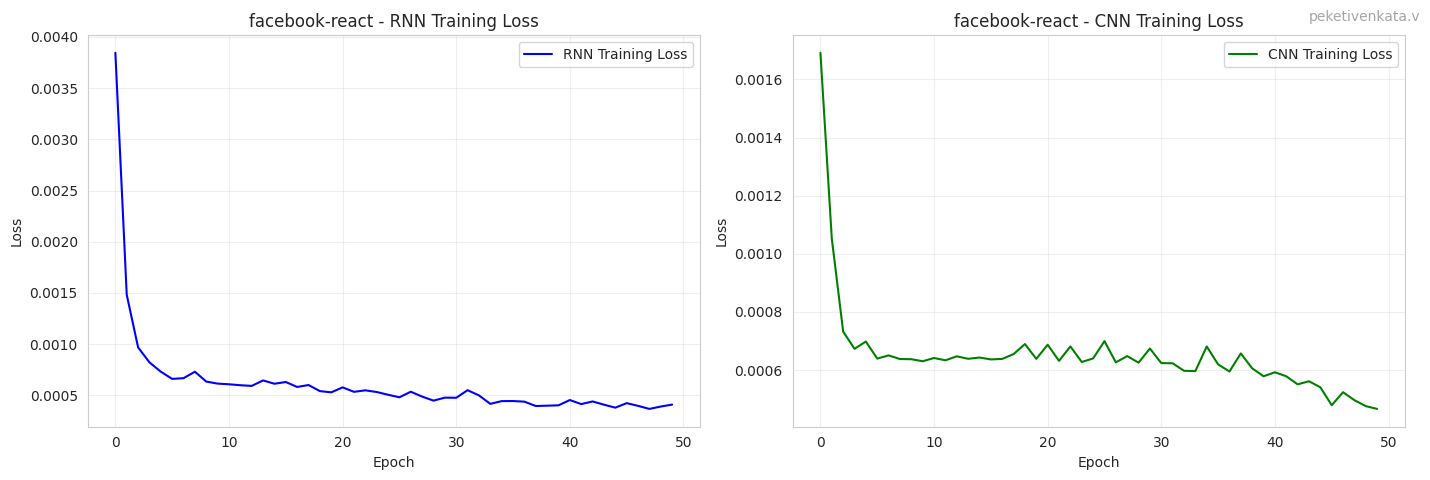

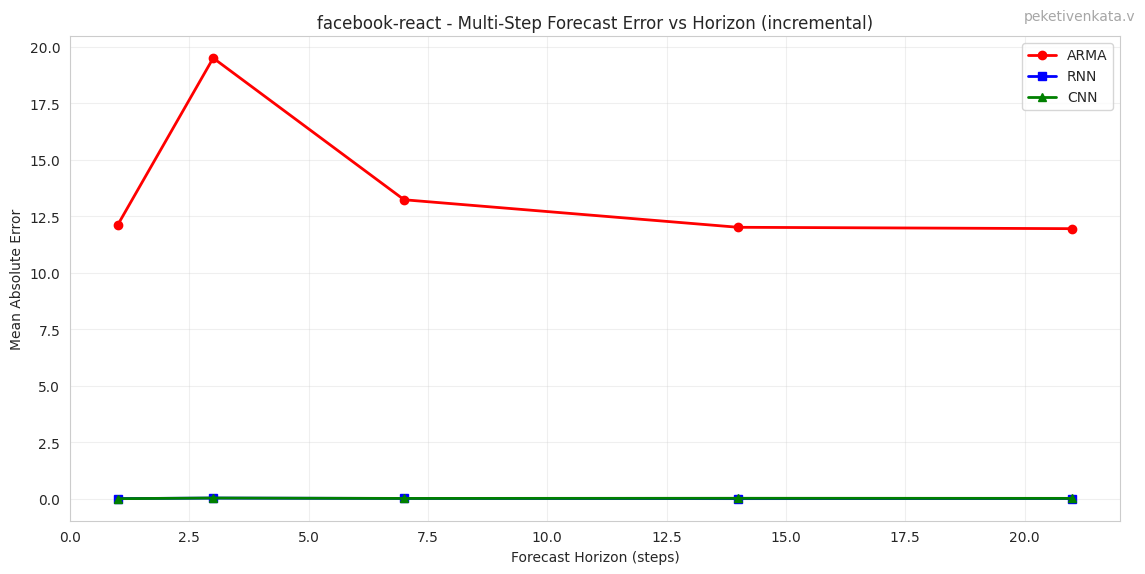


Results for facebook-react (incremental):
Model      MAE             RMSE           
----------------------------------------
ARMA       8.2576          12.2273        
RNN        8.7726          12.2831        
CNN        7.3995          12.4193        

Processing: pallets-flask

Exploring data...


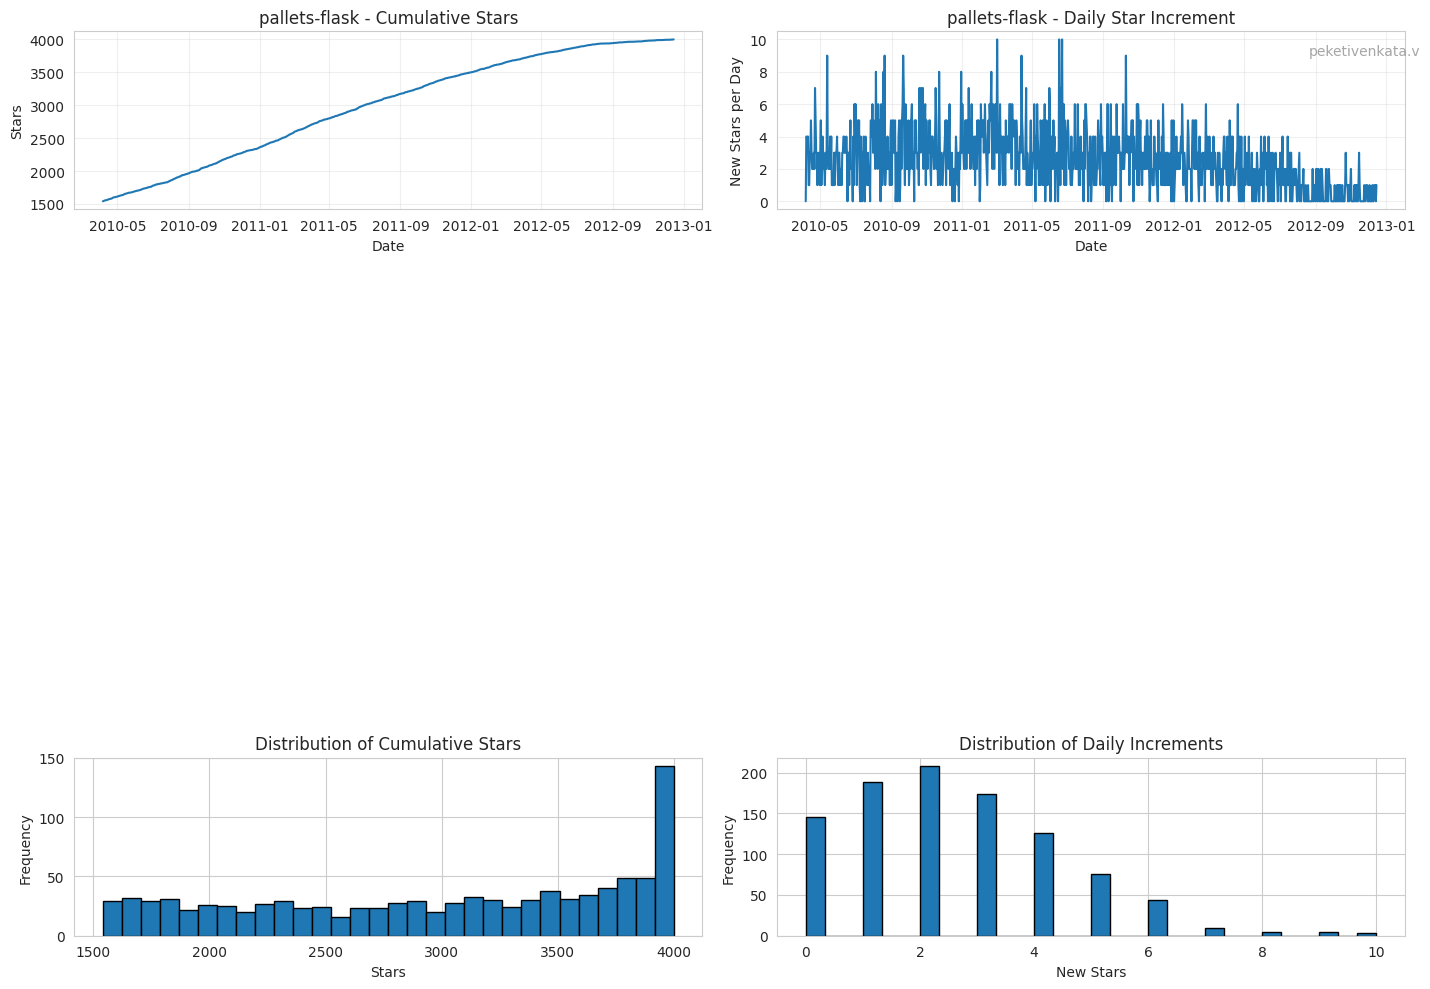


--- Processing cumulative data ---
Training and evaluating models...


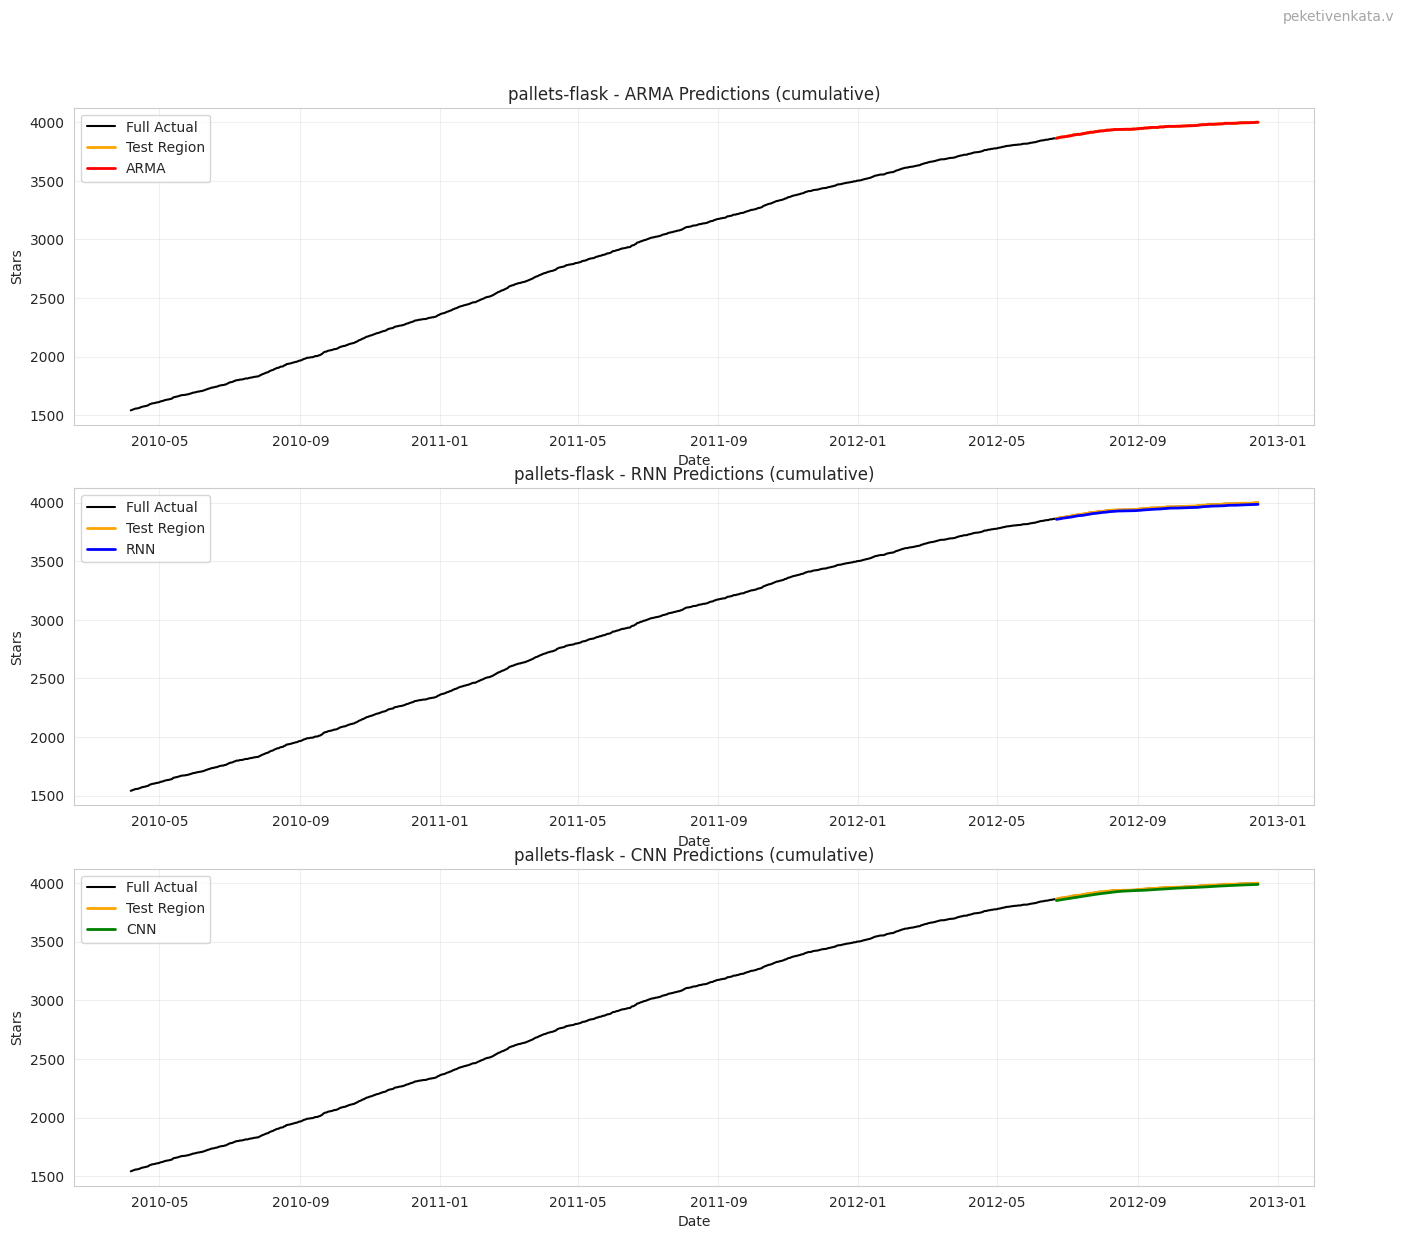

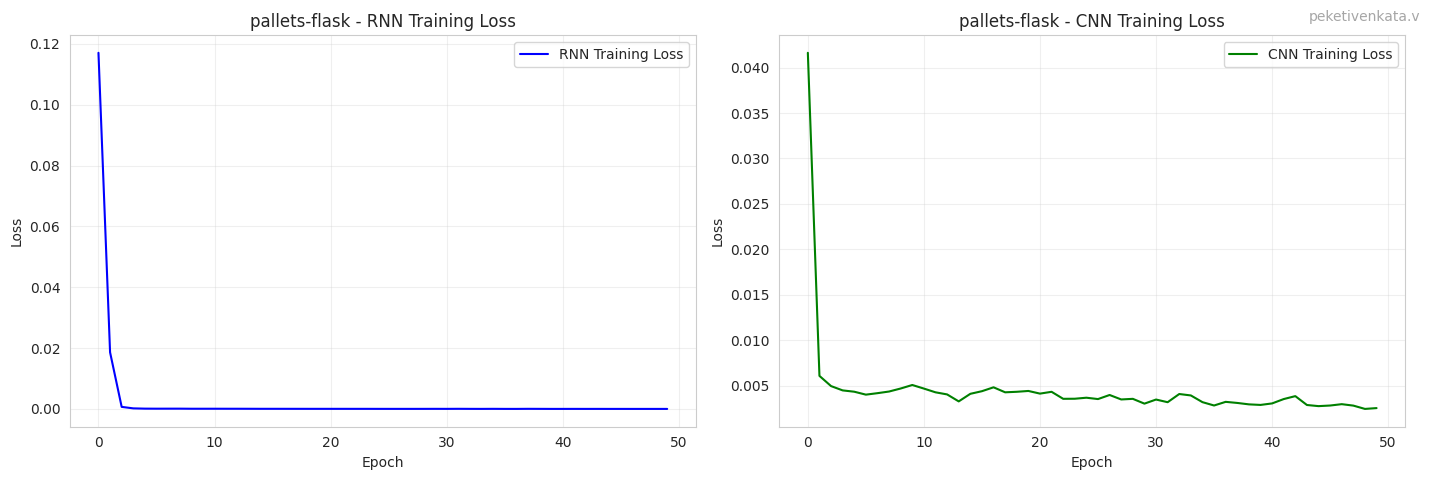

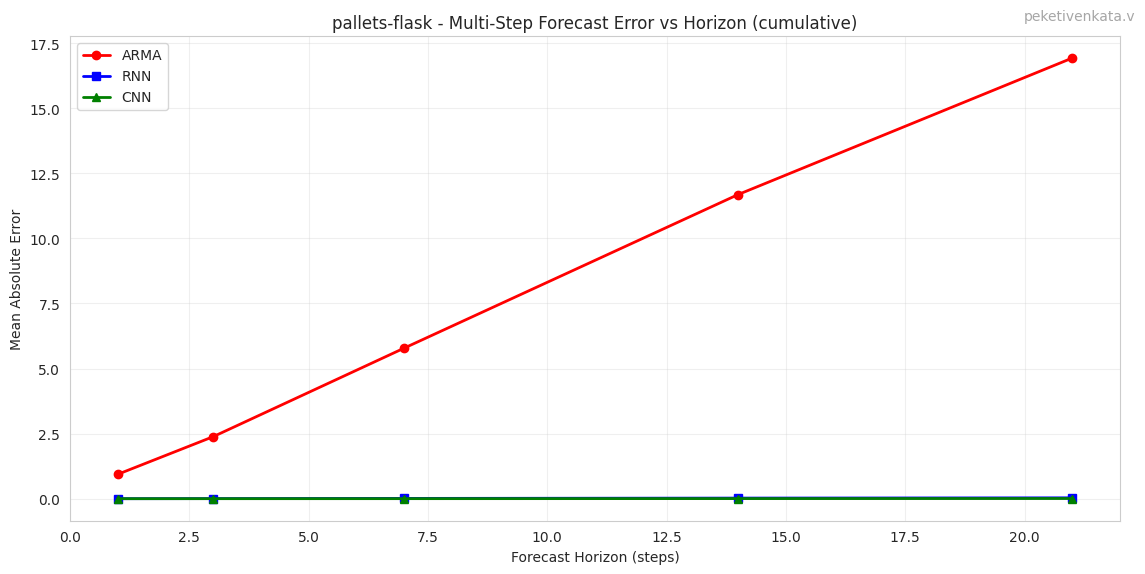


Results for pallets-flask (cumulative):
Model      MAE             RMSE           
----------------------------------------
ARMA       0.8170          1.1228         
RNN        11.4477         11.6230        
CNN        11.0149         11.3535        

--- Processing incremental data ---
Training and evaluating models...


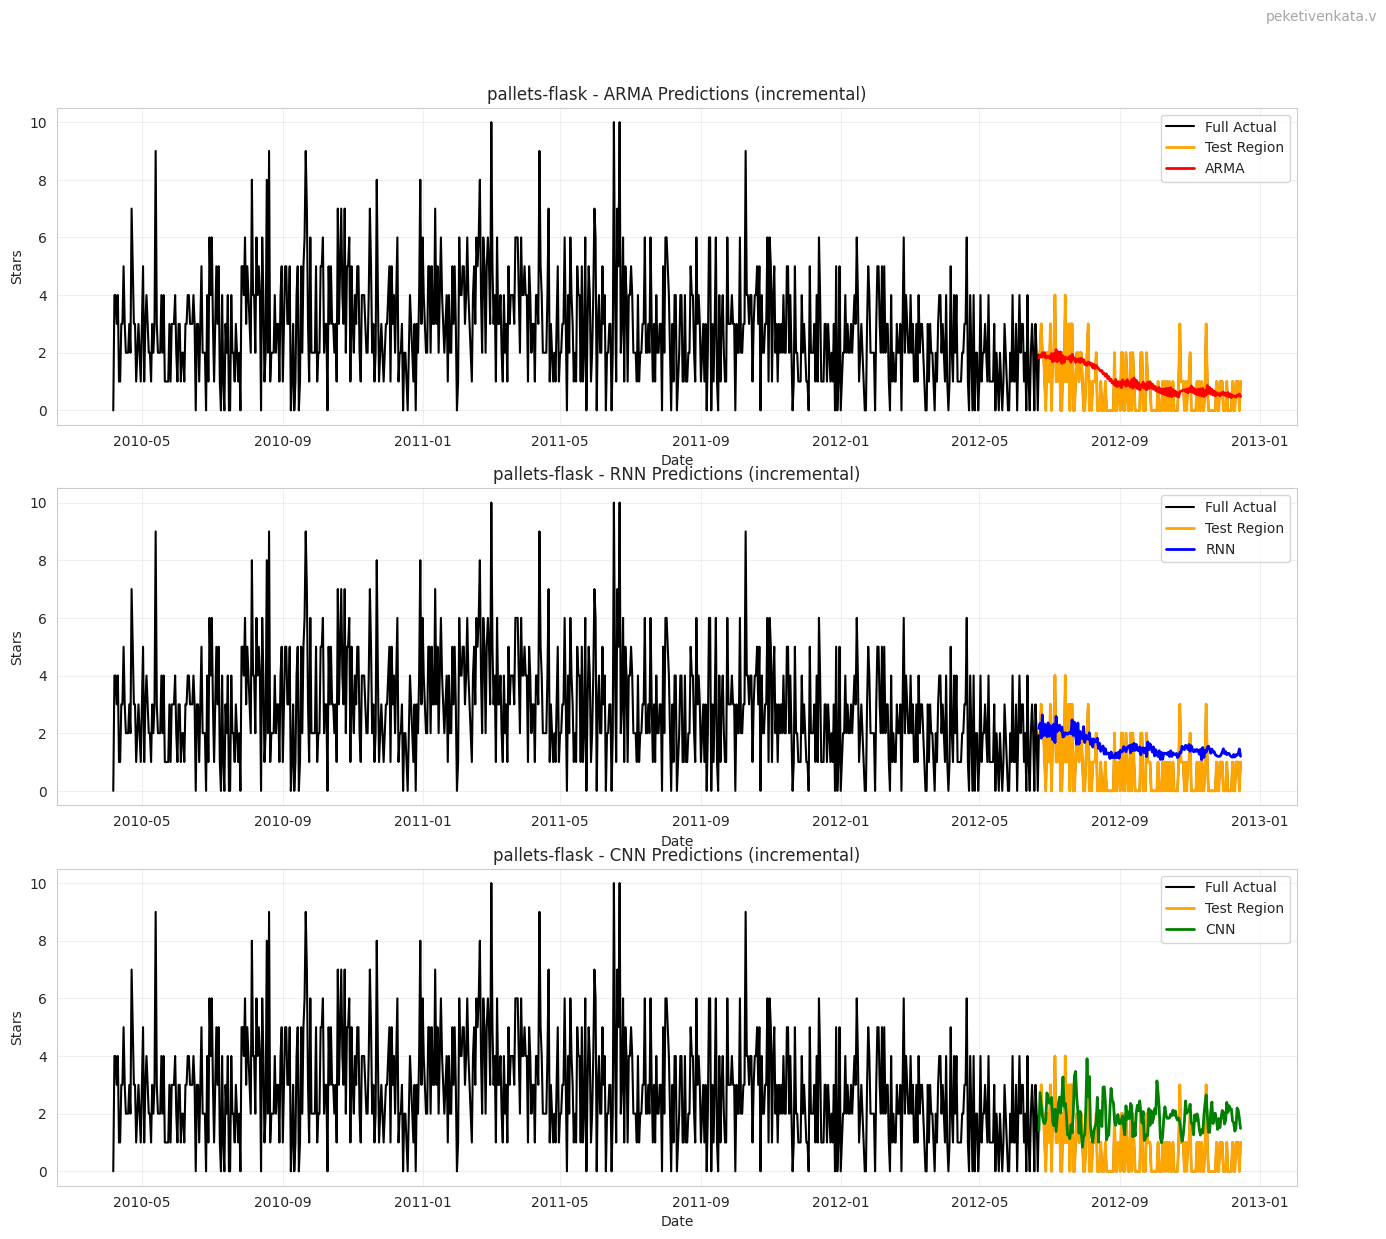

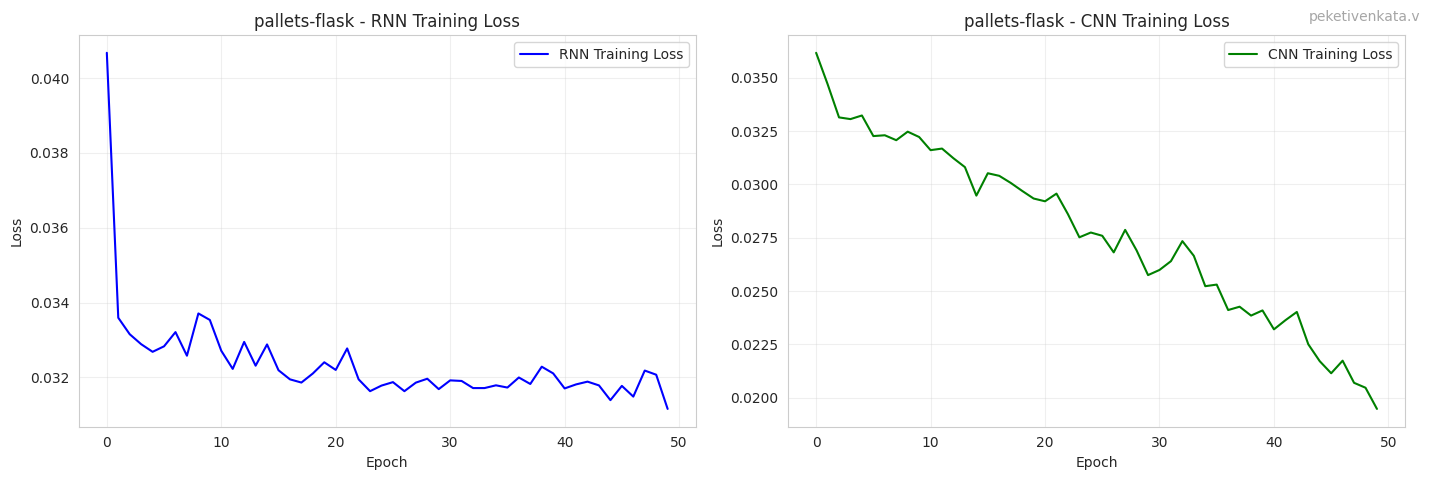

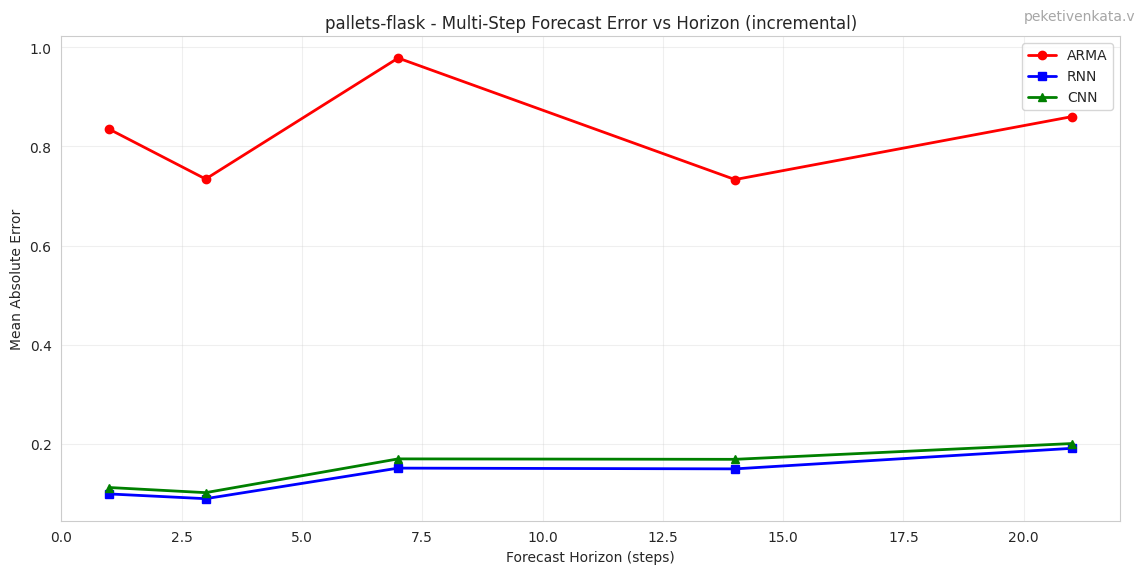


Results for pallets-flask (incremental):
Model      MAE             RMSE           
----------------------------------------
ARMA       0.7728          0.9163         
RNN        1.0107          1.1610         
CNN        1.3141          1.5169         

SUMMARY OF ALL RESULTS

facebook-react_cumulative:
  ARMA: MAE=14.3824, RMSE=20.7294
  RNN: MAE=335.7124, RMSE=340.6105
  CNN: MAE=57.6467, RMSE=72.5799

facebook-react_incremental:
  ARMA: MAE=8.2576, RMSE=12.2273
  RNN: MAE=8.7726, RMSE=12.2831
  CNN: MAE=7.3995, RMSE=12.4193

pallets-flask_cumulative:
  ARMA: MAE=0.8170, RMSE=1.1228
  RNN: MAE=11.4477, RMSE=11.6230
  CNN: MAE=11.0149, RMSE=11.3535

pallets-flask_incremental:
  ARMA: MAE=0.7728, RMSE=0.9163
  RNN: MAE=1.0107, RMSE=1.1610
  CNN: MAE=1.3141, RMSE=1.5169


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Output folder
OUTPUT_DIR = os.path.join("Outputs", "Q3")
os.makedirs(OUTPUT_DIR, exist_ok=True)

USERNAME = "peketivenkata.v"

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

class SimpleCNN(nn.Module):
    def __init__(self, seq_length=20, input_channels=1, output_size=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(128 * (seq_length // 4), 64)
        self.fc2 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class TimeSeriesForecaster:
    def __init__(self, repo_name, data_path):
        self.repo_name = repo_name
        self.df = pd.read_csv(data_path)
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.df = self.df.sort_values('timestamp').reset_index(drop=True)
        self.scaler = MinMaxScaler()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def explore_data(self):
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        axes[0, 0].plot(self.df['timestamp'], self.df['stars'])
        axes[0, 0].set_title(f'{self.repo_name} - Cumulative Stars')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Stars')
        axes[0, 0].grid(True, alpha=0.3)
        
        incremental = self.df['stars'].diff().fillna(0)
        axes[0, 1].plot(self.df['timestamp'], incremental)
        axes[0, 1].set_title(f'{self.repo_name} - Daily Star Increment')
        axes[0, 1].set_xlabel('Date')
        axes[0, 1].set_ylabel('New Stars per Day')
        axes[0, 1].grid(True, alpha=0.3)
        
        axes[1, 0].hist(self.df['stars'], bins=30, edgecolor='black')
        axes[1, 0].set_title('Distribution of Cumulative Stars')
        axes[1, 0].set_xlabel('Stars')
        axes[1, 0].set_ylabel('Frequency')
        
        axes[1, 1].hist(incremental, bins=30, edgecolor='black')
        axes[1, 1].set_title('Distribution of Daily Increments')
        axes[1, 1].set_xlabel('New Stars')
        axes[1, 1].set_ylabel('Frequency')
        
        plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
                transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'{self.repo_name}_exploration.png'), dpi=300, bbox_inches='tight')
        plt.show()
        
    def prepare_sequences(self, data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)
    
    def prepare_data(self, seq_length=20, train_ratio=0.8, use_incremental=False):
        self.seq_length = seq_length
        self.use_incremental = use_incremental
        
        if use_incremental:
            data = self.df['stars'].diff().fillna(0).values
            self.data_type = 'incremental'
        else:
            data = self.df['stars'].values
            self.data_type = 'cumulative'
        
        train_size = int(len(data) * train_ratio)
        train_data = data[:train_size]
        test_data = data[train_size:]
        
        self.train_data_raw = train_data
        self.test_data_raw = test_data
        
        train_scaled = self.scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
        test_scaled = self.scaler.transform(test_data.reshape(-1, 1)).flatten()
        
        X_train, y_train = self.prepare_sequences(train_scaled, seq_length)
        X_test, y_test = self.prepare_sequences(test_scaled, seq_length)
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.train_size = train_size
        
        return X_train, y_train, X_test, y_test
    
    def train_arma(self, order=(2, 2)):
        model = ARIMA(self.train_data_raw, order=(order[0], 0, order[1]))
        self.arma_model = model.fit()
        
    def predict_arma_single_step(self):
        predictions = []
        history = list(self.train_data_raw)
        
        for i in range(len(self.test_data_raw)):
            model = ARIMA(history, order=(2, 0, 2))
            model_fit = model.fit()
            pred = model_fit.forecast(steps=1)[0]
            predictions.append(pred)
            history.append(self.test_data_raw[i])
        
        return np.array(predictions)
    
    def predict_arma_multi_step(self, horizons=[1, 3, 7, 14]):
        errors = {h: [] for h in horizons}
        
        for start_idx in range(0, len(self.test_data_raw) - max(horizons), 5):
            history = list(self.train_data_raw) + list(self.test_data_raw[:start_idx])
            
            for h in horizons:
                if start_idx + h <= len(self.test_data_raw):
                    model = ARIMA(history, order=(2, 0, 2))
                    model_fit = model.fit()
                    pred = model_fit.forecast(steps=h)[-1]
                    actual = self.test_data_raw[start_idx + h - 1]
                    errors[h].append(abs(pred - actual))
        
        return {h: np.mean(errors[h]) for h in horizons}
    
    def train_dl_model(self, model_type='rnn', epochs=50, batch_size=32, lr=0.001):
        X_train_reshaped = self.X_train.reshape(-1, self.seq_length, 1)
        X_test_reshaped = self.X_test.reshape(-1, self.seq_length, 1)
        
        train_dataset = TimeSeriesDataset(X_train_reshaped, self.y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        if model_type == 'rnn':
            model = SimpleRNN(input_size=1, hidden_size=64, num_layers=2, output_size=1)
        else:
            model = SimpleCNN(seq_length=self.seq_length, input_channels=1, output_size=1)
        
        model = model.to(self.device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        train_losses = []
        
        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                optimizer.zero_grad()
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            train_losses.append(epoch_loss / len(train_loader))
        
        if model_type == 'rnn':
            self.rnn_model = model
            self.rnn_losses = train_losses
        else:
            self.cnn_model = model
            self.cnn_losses = train_losses
        
        return model, train_losses
    
    def predict_dl_single_step(self, model):
        model.eval()
        X_test_reshaped = self.X_test.reshape(-1, self.seq_length, 1)
        X_test_tensor = torch.FloatTensor(X_test_reshaped).to(self.device)
        
        with torch.no_grad():
            predictions = model(X_test_tensor).squeeze().cpu().numpy()
        
        return predictions
    
    def predict_dl_multi_step(self, model, horizons=[1, 3, 7, 14]):
        model.eval()
        errors = {h: [] for h in horizons}
        
        for start_idx in range(0, len(self.X_test) - max(horizons), 5):
            for h in horizons:
                if start_idx + h <= len(self.X_test):
                    current_seq = self.X_test[start_idx].copy()
                    
                    for step in range(h):
                        seq_tensor = torch.FloatTensor(current_seq.reshape(1, self.seq_length, 1)).to(self.device)
                        with torch.no_grad():
                            pred = model(seq_tensor).squeeze().cpu().item()
                        
                        current_seq = np.roll(current_seq, -1)
                        current_seq[-1] = pred
                    
                    actual = self.y_test[start_idx + h - 1]
                    errors[h].append(abs(pred - actual))
        
        return {h: np.mean(errors[h]) for h in horizons}
    
    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data.reshape(-1, 1)).flatten()
    
    def evaluate_all_models(self):
        self.train_arma()
        arma_preds = self.predict_arma_single_step()
        
        rnn_model, _ = self.train_dl_model('rnn', epochs=50)
        rnn_preds_scaled = self.predict_dl_single_step(rnn_model)
        rnn_preds = self.inverse_transform(rnn_preds_scaled)
        
        cnn_model, _ = self.train_dl_model('cnn', epochs=50)
        cnn_preds_scaled = self.predict_dl_single_step(cnn_model)
        cnn_preds = self.inverse_transform(cnn_preds_scaled)
        
        test_actual = self.test_data_raw[self.seq_length:]
        
        results = {
            'ARMA': {
                'MAE': mean_absolute_error(test_actual, arma_preds[self.seq_length:]),
                'RMSE': np.sqrt(mean_squared_error(test_actual, arma_preds[self.seq_length:]))
            },
            'RNN': {
                'MAE': mean_absolute_error(test_actual, rnn_preds),
                'RMSE': np.sqrt(mean_squared_error(test_actual, rnn_preds))
            },
            'CNN': {
                'MAE': mean_absolute_error(test_actual, cnn_preds),
                'RMSE': np.sqrt(mean_squared_error(test_actual, cnn_preds))
            }
        }
        
        # plot full series + test region + predictions
        self.plot_predictions(test_actual, arma_preds[self.seq_length:], rnn_preds, cnn_preds)
        self.plot_training_losses()
        
        horizons = [1, 3, 7, 14, 21]
        arma_multi = self.predict_arma_multi_step(horizons)
        rnn_multi = self.predict_dl_multi_step(rnn_model, horizons)
        cnn_multi = self.predict_dl_multi_step(cnn_model, horizons)
        
        self.plot_multi_step_errors(horizons, arma_multi, rnn_multi, cnn_multi)
        
        return results
    
    def plot_predictions(self, actual, arma_preds, rnn_preds, cnn_preds):
        # Full series based on mode
        if self.use_incremental:
            full_data = self.df['stars'].diff().fillna(0).values
        else:
            full_data = self.df['stars'].values

        # --- X-axis as dates ---
        dates_full = self.df['timestamp'].values
        test_start = self.train_size + self.seq_length
        dates_test = dates_full[test_start : test_start + len(actual)]

        fig, axes = plt.subplots(3, 1, figsize=(16, 14))

        def plot_one(ax, preds, title, color):
            # Plot full data
            ax.plot(dates_full, full_data, label="Full Actual", color="black", linewidth=1.5)

            # Highlight test region
            ax.plot(dates_test, full_data[test_start:test_start+len(actual)],
                    label="Test Region", color="orange", linewidth=2)

            # Predictions
            ax.plot(dates_test, preds, label=title, color=color, linewidth=2)

            ax.set_title(f"{self.repo_name} - {title} Predictions ({self.data_type})")
            ax.set_xlabel("Date")
            ax.set_ylabel("Stars")
            ax.legend()
            ax.grid(True, alpha=0.3)

        plot_one(axes[0], arma_preds, "ARMA", "red")
        plot_one(axes[1], rnn_preds, "RNN", "blue")
        plot_one(axes[2], cnn_preds, "CNN", "green")

        plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
                transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"{self.repo_name}_{self.data_type}_predictions.png"),
                    dpi=300, bbox_inches="tight")
        plt.show()


    
    def plot_training_losses(self):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        axes[0].plot(self.rnn_losses, label='RNN Training Loss', color='blue')
        axes[0].set_title(f'{self.repo_name} - RNN Training Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(self.cnn_losses, label='CNN Training Loss', color='green')
        axes[1].set_title(f'{self.repo_name} - CNN Training Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
                transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'{self.repo_name}_{self.data_type}_training_losses.png'), dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_multi_step_errors(self, horizons, arma_errors, rnn_errors, cnn_errors):
        fig, ax = plt.subplots(figsize=(12, 6))
        
        arma_vals = [arma_errors[h] for h in horizons]
        rnn_vals = [rnn_errors[h] for h in horizons]
        cnn_vals = [cnn_errors[h] for h in horizons]
        
        ax.plot(horizons, arma_vals, marker='o', label='ARMA', color='red', linewidth=2)
        ax.plot(horizons, rnn_vals, marker='s', label='RNN', color='blue', linewidth=2)
        ax.plot(horizons, cnn_vals, marker='^', label='CNN', color='green', linewidth=2)
        
        ax.set_title(f'{self.repo_name} - Multi-Step Forecast Error vs Horizon ({self.data_type})')
        ax.set_xlabel('Forecast Horizon (steps)')
        ax.set_ylabel('Mean Absolute Error')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.text(0.95, 0.95, USERNAME, ha='right', va='top',
                transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'{self.repo_name}_{self.data_type}_multistep_errors.png'), dpi=300, bbox_inches='tight')
        plt.show()

if __name__ == "__main__":
    repos = [
        ('facebook-react', 'facebook-react_cleaned.csv'),
        ('pallets-flask', 'pallets-flask_cleaned.csv')
    ]
    
    all_results = {}
    
    for repo_name, data_path in repos:
        print(f"\n{'='*60}")
        print(f"Processing: {repo_name}")
        print(f"{'='*60}\n")
        
        forecaster = TimeSeriesForecaster(repo_name, data_path)
        
        print("Exploring data...")
        forecaster.explore_data()
        
        for use_incremental in [False, True]:
            data_type = 'incremental' if use_incremental else 'cumulative'
            print(f"\n--- Processing {data_type} data ---")
            
            forecaster.prepare_data(seq_length=20, train_ratio=0.8, use_incremental=use_incremental)
            
            print("Training and evaluating models...")
            results = forecaster.evaluate_all_models()
            
            all_results[f"{repo_name}_{data_type}"] = results
            
            print(f"\nResults for {repo_name} ({data_type}):")
            print(f"{'Model':<10} {'MAE':<15} {'RMSE':<15}")
            print("-" * 40)
            for model, metrics in results.items():
                print(f"{model:<10} {metrics['MAE']:<15.4f} {metrics['RMSE']:<15.4f}")
    
    print("\n" + "="*60)
    print("SUMMARY OF ALL RESULTS")
    print("="*60)
    for key, results in all_results.items():
        print(f"\n{key}:")
        for model, metrics in results.items():
            print(f"  {model}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}")


# Forecasting GitHub Repository Stars
## ARMA, RNN, and 1D CNN Models

**Author:** Aditya Peketi

---

## 1. Introduction
This report presents forecasting experiments conducted on two GitHub repositories: **`facebook-react`** and **`pallets-flask`**. I have visually check the csv file and have picked these two and I have observed that every repo saturates after 4000 stars so I have cleaned the data.

The objective is to model and predict future **cumulative star counts** using three approaches:
1.  **Classical statistical model:** ARMA.
2.  **Deep learning models:** Simple RNN and 1D CNN.

---

## 2. Data Preparation
Each dataset contains a timestamp column and a cumulative star count. Data preprocessing included:

* **Time Series Preparation:** Parsing timestamps as datetime objects and sorting chronologically.
* **Train-Test Split:** Using an **80–20 chronological split** for training and testing.
* **Normalization:** Scaling only the training portion with **MinMaxScaler**; test data reused the same fit.
* **Supervised Learning Format:** Converting the time series into supervised learning format using a **sliding window of 20 steps** (the lookback window):
    * Input Sequence: $X_t = [s_{t-19}, \ldots, s_t]$
    * Target Value: $y_{t+1} = s_{t+1}$

> ARMA models used the raw cumulative training series directly without scaling.

---

## 3. Forecasting Models

### 3.1 ARMA Model
A classical **ARMA(2,2)** model was fitted using `statsmodels`.

It performs **one-step-ahead recursive forecasting** over the test region by refitting the model at each step (Rolling Forecast Origin). Although cumulative time series are typically **nonstationary** (they exhibit a clear trend), ARMA is included for baseline comparison.

### 3.2 Simple RNN
The **RNN** architecture consisted of:
* Two recurrent layers with **64 hidden units**.
* A fully connected output layer.

It receives a $20 \times 1$ sequence and predicts the next cumulative star value. Training used the Adam optimizer for 50 epochs. RNNs can model temporal dependencies but may struggle with long-range patterns due to **vanishing gradients**.

### 3.3 1D CNN Forecaster
The **1D CNN** architecture consisted of:
* **Conv1D** layer with 64 filters.
* **MaxPooling** layer.
* **Conv1D** layer with 128 filters.
* **MaxPooling** layer.
* **Dense layers** (64 units then 1 output).

This model extracts **local temporal patterns** efficiently and trains significantly faster than the RNN. CNNs handle nonlinear dynamics well and often generalize better on cumulative series.

---

## 4. Quantitative Results
Each model was evaluated using **Mean Absolute Error (MAE)** and **Root Mean Squared Error (RMSE)** over the test region. A typical results table is shown below:

| Repository & Domain            | Model | MAE       | RMSE      |
|--------------------------------|-------|-----------|-----------|
| facebook-react (Cumulative)    | ARMA  | 14.3824   | 20.7294   |
|                                | RNN   | 335.7124  | 340.6105  |
|                                | CNN   | 57.6467   | 72.5799   |
| facebook-react (Incremental)   | ARMA  | 8.2576    | 12.2273   |
|                                | RNN   | 8.7726    | 12.2831   |
|                                | CNN   | 7.3995    | 12.4193   |
| pallets-flask (Cumulative)     | ARMA  | 0.8170    | 1.1228    |
|                                | RNN   | 11.4477   | 11.6230   |
|                                | CNN   | 11.0149   | 11.3535   |
| pallets-flask (Incremental)    | ARMA  | 0.7728    | 0.9163    |
|                                | RNN   | 1.0107    | 1.1610    |
|                                | CNN   | 1.3141    | 1.5169    |


---

**Please look at the notebook/gdrive link for the plots**